<a href="https://colab.research.google.com/github/elenakelly/EurovisionTextAnalysis/blob/main/Eurovision_Song_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import warnings
from nltk.chunk import ne_chunk
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import word_tokenize, pos_tag, sent_tokenize
import spacy
import plotly.express as px

warnings.filterwarnings("ignore")

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is al

True

In [ ]:
df = pd.read_json("eurovision-lyrics-2022.json", orient="index")
print(df.shape)
df.head()

(1684, 14)


,#,Country,#.1,Artist,Song,Language,Pl.,Sc.,Eurovision_Number,Year,Host_Country,Host_City,Lyrics,Lyrics translation
0,1,Netherlands,1,Jetty Paerl,De vogels van Holland,Dutch,-,-,1,1956,Switzerland,Lugano,De vogels van Holland zijn zo muzikaal\nZe ler...,The birds of Holland are so musical\nThey alre...
1,2,Switzerland,1,Lys Assia,Das alte Karussell,German,-,-,1,1956,Switzerland,Lugano,Das alte Karussell\nDas geht nicht mehr so sch...,The old carousel\nIt doesn't go as fast anymor...
2,3,Belgium,1,Fud Leclerc,Messieurs les noyés de la Seine,French,-,-,1,1956,Switzerland,Lugano,Messieurs les noyés de la Seine\nOuvrez-moi le...,Ye drowned men of the river Seine (1)\nOpen th...
3,4,Germany (West),1,Walter Andreas Schwarz,Im Wartesaal zum großen Glück,German,-,-,1,1956,Switzerland,Lugano,Es gibt einen Hafen\nDa fährt kaum ein Schiff\...,There is a harbour\nWhere hardly any ship leav...
4,5,France,1,Mathé Altéry,Le temps perdu,French,-,-,1,1956,Switzerland,Lugano,"Chante, carillon\nLe chant du temps perdu\nCha...","Sing, carillon\nThe song of lost time\nSing yo..."


* pl: place in the final result table
* sc: total score in points

In [ ]:
df_infos = pd.read_csv("Eurovision Winners - Winner Data KG-3.csv")
print(df_infos.shape)
df_infos.head()

(70, 9)


,Year,Country,Song,Artist,Songwriter(s),Running Order,Semi Final Points,Total Points,Location
0,1956,Switzerland,"""Refrain""",Lys Assia,Géo Voumard\nÉmile Gardaz,9.0,NaN,0.0,Lugano
1,1957,Netherlands,"""Net als toen""",Corry Brokken,Guus Jansen\nWilly van Hemert,6.0,NaN,31.0,Frankfurt
2,1958,France,"""Dors, mon amour""",André Claveau,Hubert Giraud\nPierre Delanoë,3.0,NaN,27.0,Hilversum
3,1959,Netherlands,"""Een beetje""",Teddy Scholten,Dick Schallies\nWilly van Hemert,5.0,NaN,21.0,Cannes
4,1960,France,"""Tom Pillibi""",Jacqueline Boyer,André Popp\nPierre Cour,13.0,NaN,32.0,London


# Preprocessing
Data preprocessing is of great importance in NLP projects. Data preprocessing steps are used to make the raw dataset workable, meaningful and suitable for modelling.

In [ ]:
# Replacing the word "English" with the lyrics instead of the songs in English in the Lyric translation section.
english_lyrics = df[df["Lyrics translation"] == "English"]["Lyrics"]
df.loc[df["Lyrics translation"] == "English", "Lyrics translation"]= english_lyrics

<b>Data Cleaning:</b> Data preprocessing involves cleaning up unnecessary or noisy data. Steps such as removing unnecessary information such as special characters, numbers, punctuation marks, correcting typos or removing irregularities improve the quality of the data.

In [ ]:
# helper function
def remove_spaces(df):
    # remove \n
    df["Lyrics translation"]=df["Lyrics translation"].str.replace('\n', ' ') 
    # convert multiple spaces to single spaces
    df["Lyrics translation"] = df["Lyrics translation"].str.replace(' \s+', ' ', regex=True) 
    # removes leading and trailing spaces
    df["Lyrics translation"]=df["Lyrics translation"].str.replace('^\s+', '', regex=True) #front 
    df["Lyrics translation"]=df["Lyrics translation"].str.replace('\s+$', '', regex=True) #end 

    return df 

df = remove_spaces(df)

In [ ]:
def norm_doc(single_doc): 
    single_doc = re.sub(r"[^\w\s]", " ", single_doc)  # remove special characters
    single_doc = re.sub("w*[0-9]+", " ", single_doc)  # remove numbers
    return single_doc 

norm_docs = np.vectorize(norm_doc) 
df["Lyrics translation"] = norm_docs(df["Lyrics translation"]) 

In [ ]:
# Creation of new lowercase prep_lyric variable. All operations will be performed on this variable.
df["prep_lyric"] = df["Lyrics translation"].str.lower()

# Correction of abbreviations
df["prep_lyric"] = df["prep_lyric"].str.replace("won't", "will not").replace("can't", "can not").replace("n't", " not").replace("'ll", " will").replace("'re", " are").replace("'ve", " have").replace("'m", " am").replace("'d", " would")

<b>Lemmatization: </b> lemmatization of words in texts provides semantic consolidation by combining word variations. These steps are used to capture semantic similarity at the word level and are often based on grammar rules.

In [ ]:
# Application of the lemmatizer process
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word,pos='v') for word in words]
    return ' '.join(words)

df['prep_lyric'] = df['prep_lyric'].apply(lemmatize_words)

<b>Removing Stop Words:</b> Stop words are frequently used words such as grammatical conjunctions, prepositions, and pronouns. As these words often do not have semantic significance, they can create noise in the analysis and modeling processes. Stop words removal aims to obtain more focused and meaningful texts by filtering these words.

In [ ]:
# removing stopwords
stop = stopwords.words('english')

# Adding words that could be stopwords for this dataset
stop = stop + ["lala","ooh","sing","gonna","wanna","hey","new","nana","lalala","gotta","yes","may","lala","gave","ever","many","without","much","let","yeah","take","make","know","would","tell","make",
               "come","get","one","two","want","see","away","look","always","give","say","even","every","everything","everybody","run","could","should","day","cause","chorus","yay","duh",
               "yum","lai","lee","mikado","true","diggi","aah","bang","shi","dong","tom","pillibi","boom","duy","cululoo","para","nanana","jennie","rimi","hule","lalalala","moni","ela","dap",
               "yerde","hoo","nigar","aman","hiah","dai","doba","gasimov"]

df["prep_lyric"] = df["prep_lyric"].str.lower().str.split()
df["prep_lyric"] = df["prep_lyric"].apply(lambda x: [item for item in x if item not in stop])
df = df.assign(prep_lyric=df.prep_lyric.map(' '.join))

In [ ]:
# Words greater than 15 in length are subtracted
def remove_long_words(single_doc): 
    single_doc = re.sub(r'\b\w{15,100}\b', '', single_doc)
    return single_doc

# Removing words less than 3 in length in a sentence
def remove_small_words(single_doc):
    single_doc = re.sub(r'\b\w{1,2}\b', '', single_doc)#iki harften küçükler
    return single_doc

remove_long_words = np.vectorize(remove_long_words)
df["prep_lyric"] = remove_long_words(df["prep_lyric"])

remove_small_words = np.vectorize(remove_small_words)
df["prep_lyric"] = remove_small_words(df["prep_lyric"])

In [ ]:
text = " ".join(review for review in df.prep_lyric)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 857697 words in the combination of all review.


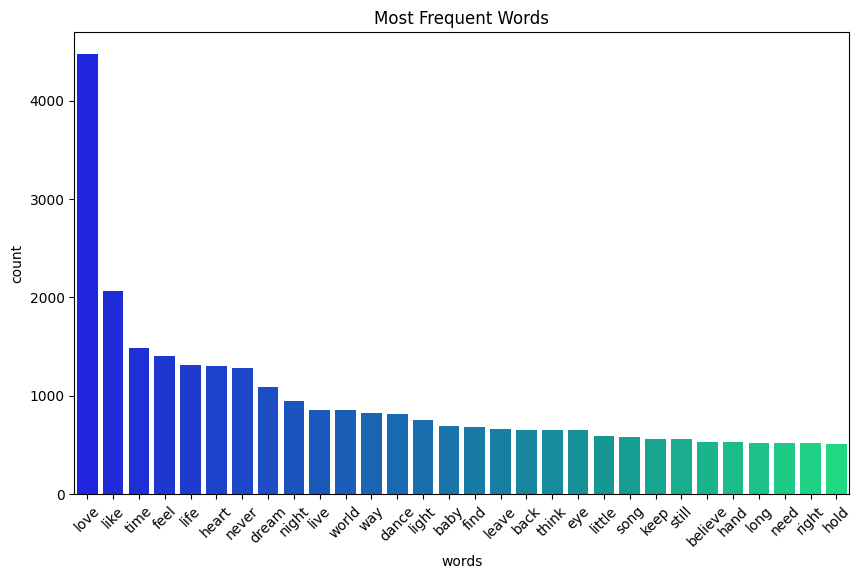

In [ ]:
# Import Counter 
from collections import Counter

# Join all word corpus
review_words = ','.join(list(df['prep_lyric'].values))

# Count and find the 30 most frequent
counter = Counter(review_words.split())
most_frequent = counter.most_common(30)

# Bar plot of frequent words
fig = plt.figure(1, figsize = (10,6))
_ = pd.DataFrame(most_frequent, columns=("words","count"))
sns.barplot(x = 'words', y = 'count', data = _, palette = 'winter')
plt.title("Most Frequent Words");
plt.xticks(rotation=45);

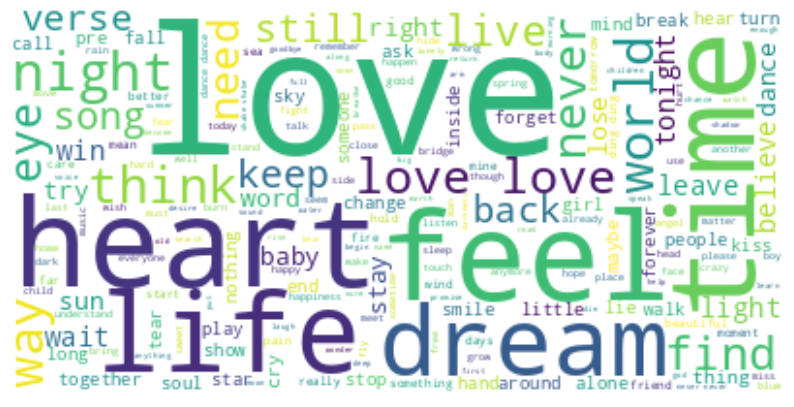

In [ ]:
# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Topic Modelling

## TF-IDF
* TfidfVectorizer is a vectorization tool used to perform the "Term Frequency-Inverse Document Frequency" (TF-IDF) conversion. It is a component frequently used in text analysis studies such as topic modeling.

* TfidfVectorizer is used to represent text data with a numeric vector. This vectorization process uses TF-IDF scores to determine the importance of words in each document.

* TF (Term Frequency) refers to how often a word occurs in a document. The higher the frequency of a word in the document, the more important that word is for that document.

* IDF (Inverse Document Frequency) refers to how rare a word is in all documents. Rare words usually carry more information and have more distinctive features.

* TfidfVectorizer is a tool for representing text data with a numerical vector and calculating the significance of each word among documents. It is frequently used in text analysis studies such as topic modeling to determine word importance and to make texts comparable.

## LDA
* LDA (Latent Dirichlet Allocation) is a probability model used in text datasets and is a widely used method for topic analysis. Topic analysis is a technique used to understand the content of documents and to discover the main themes that represent the documents.

* LDA assumes that each document belongs to one or more topics and aims to find the distribution of these topics in the documents. Based on the probability distribution of the documents in the text dataset, LDA tries to find the hidden topics and the distribution of the words they contain.

In [ ]:
# TF-IDF Vectorizer for lyric data
vectorizer = TfidfVectorizer(stop_words = stop, min_df=0.1 ,max_df=0.20)
tfifd = vectorizer.fit_transform(df['prep_lyric'])

# Define Search Param
search_params = {'n_components': range(5,15), 'learning_decay': [.5, .7, .9]}
# Init the Model
lda = LatentDirichletAllocation(max_iter=5 ,random_state=0)
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(tfifd)

GridSearchCV(estimator=LatentDirichletAllocation(max_iter=5, random_state=0),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': range(5, 15)})

In [ ]:
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 5}


In [ ]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(tfifd)
# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]
# index names
docnames = ["Doc" + str(i) for i in range(len(df))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic["dominant_topic"] = dominant_topic
# distribution of topics
df_document_topic.dominant_topic.value_counts()

0    456
1    368
3    298
4    283
2    279
Name: dominant_topic, dtype: int64

In [ ]:
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,back,leave,long,forget,word,lose,alone,hear,soul,still,turn,wait,try,keep,fall
Topic 1,hold,hand,good,walk,right,tear,inside,cry,stay,people,end,stop,little,need,fall
Topic 2,light,sun,sky,star,little,play,fall,fly,mind,long,around,still,turn,hear,end
Topic 3,verse,believe,need,keep,win,break,still,try,stay,lose,fly,stop,alone,cry,mind
Topic 4,dance,song,together,nothing,wait,play,stop,fly,right,smile,people,around,sun,hand,hear


## Appropriate names for the topics found in the LDA result
* Topic 0: "Moving On and Letting Go"
* Topic 1: "Emotional Connections"
* Topic 2: "Dreams and Wonder"
* Topic 3: "Struggles and Determination"
* Topic 4: "Joyful Rhythms and Togetherness"

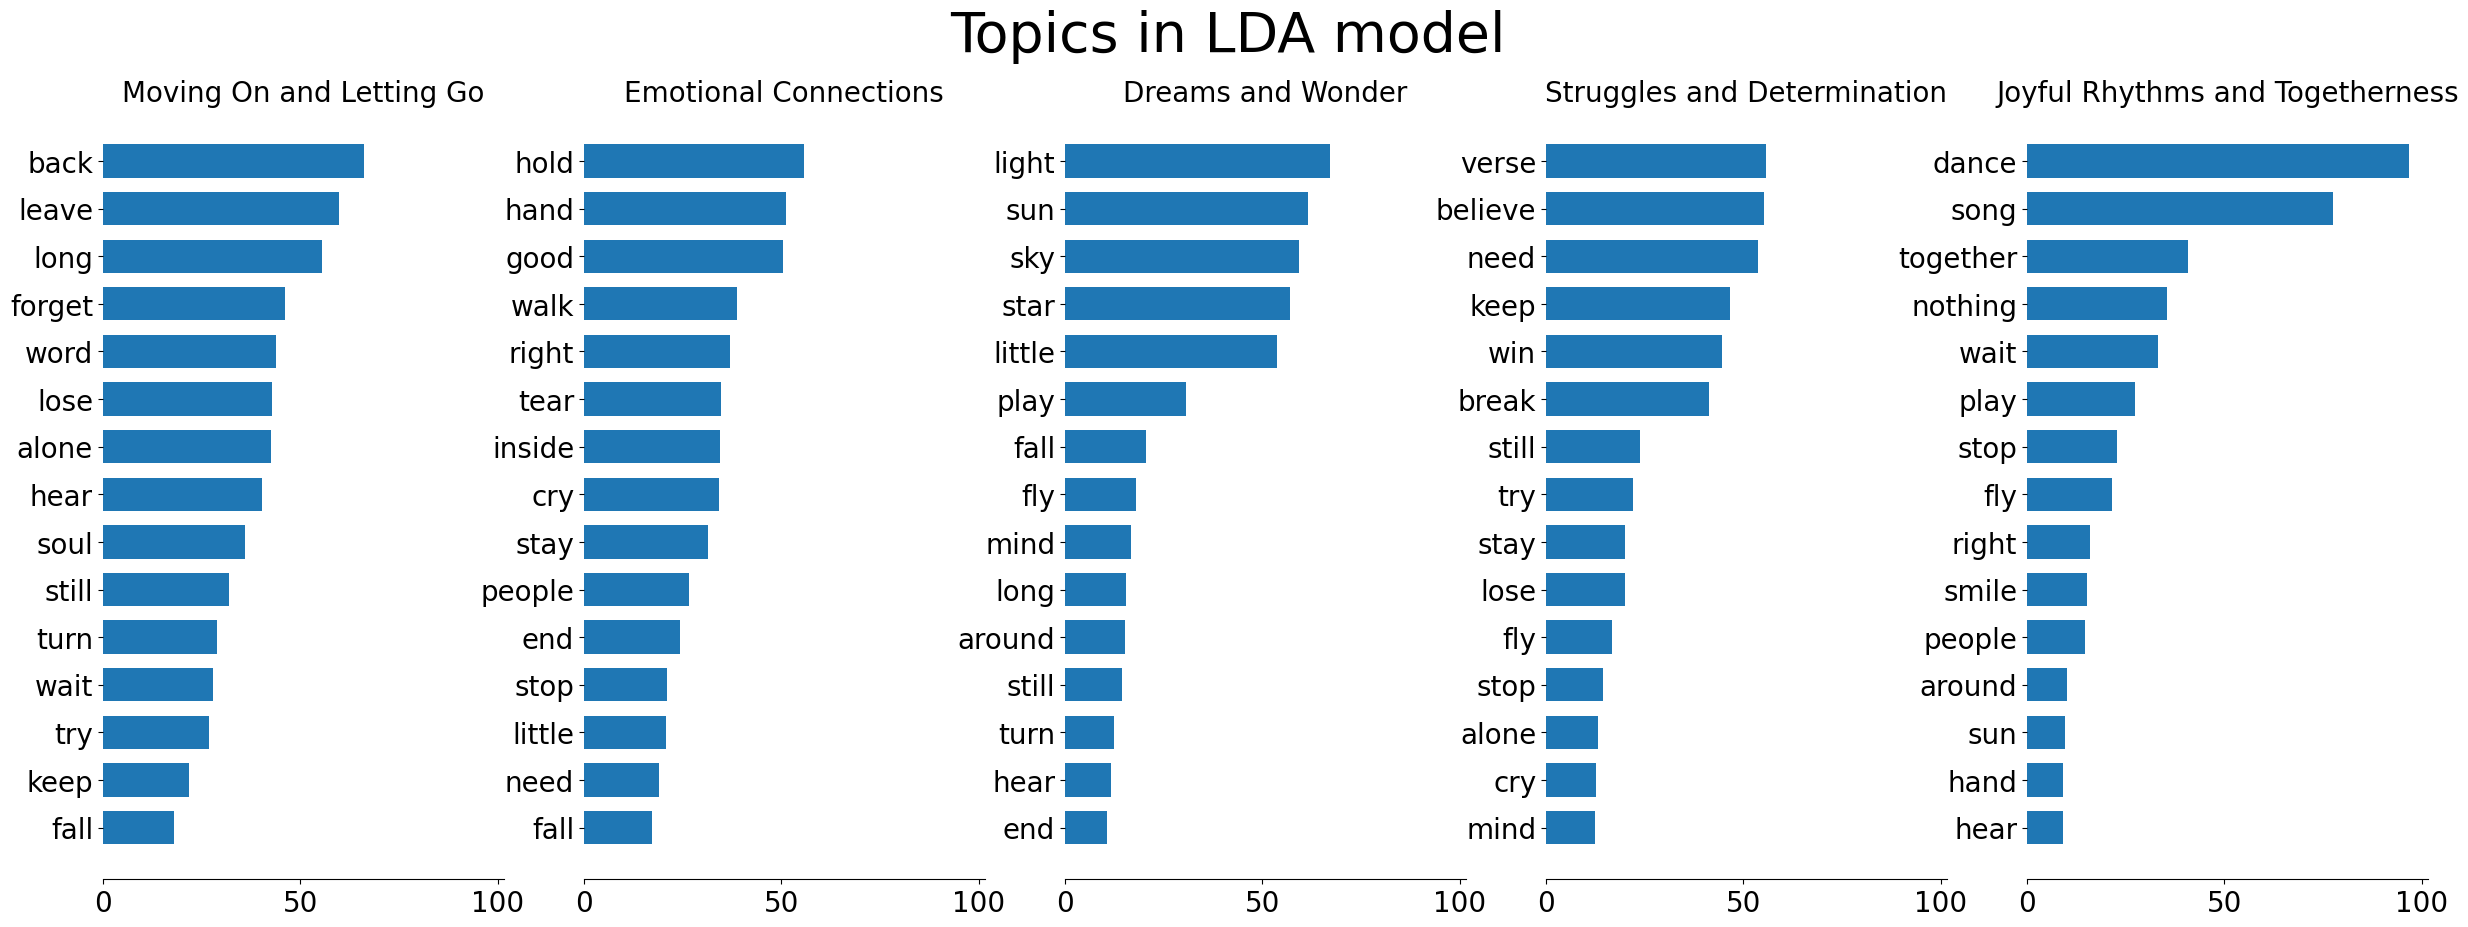

In [ ]:
# Define a function for plotting the distribution of most frequent words for topics
def plot_top_words(model, feature_names, n_top_words, title):
    # Create a figure with 1 row and 5 columns, with shared x-axis
    fig, axes = plt.subplots(1, 5, figsize=(30, 10), sharex=True)
    axes = axes.flatten()

    # Define the names of the topics
    topic_names = ["Moving On and Letting Go", "Emotional Connections", "Dreams and Wonder", "Struggles and Determination", "Joyful Rhythms and Togetherness"]
    
    # Iterate over each topic in the model
    for topic_idx, topic in enumerate(model.components_):
        # Get the indices of the top n_top_words features in the topic
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        # Get the actual feature names using the indices
        top_features = [feature_names[i] for i in top_features_ind]
        # Get the weights of the top features in the topic
        weights = topic[top_features_ind]

        # Get the corresponding axis for the current topic
        ax = axes[topic_idx]
        # Create a horizontal bar plot of the top features and their weights
        ax.barh(top_features, weights, height=0.7)
        # Set the title of the subplot to the name of the topic
        ax.set_title(topic_names[topic_idx], fontdict={"fontsize": 20})
        # Invert the y-axis to show the most important words on top
        ax.invert_yaxis()
        # Set the tick label font size for both axes
        ax.tick_params(axis="both", which="major", labelsize=20)
        # Hide the spines (borders) on the top, right, and left sides of the subplot
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        # Set the overall title of the figure
        fig.suptitle(title, fontsize=40)

    # Display the plot
    plt.show()

# Get the feature names from the vectorizer
tf_feature_names = vectorizer.get_feature_names_out()
# Call the function to plot the top words for each topic in the best LDA model
plot_top_words(best_lda_model, tf_feature_names, 15, "Topics in LDA model")


# Post-Processing Data

In post-processing, the results from LDA are combined with the main dataframe. While examining the LDA probability results, those below 40% were allocated to a different dataframe. Since this probability ratio was considered low, a different procedure was applied. In this process, if the probability rate of all topics is 20%, the dominant topic of the relevant song is replaced with "mix". If not all of them are 20%, the 2 biggest topics with probability value less than 40% were selected and the dominant topic of the relevant song was created by combining these two topics.

In [ ]:
df_document_topic = df_document_topic.reset_index(drop=True)
df_document_topic.head(2)

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
0,0.49,0.08,0.28,0.08,0.08,0
1,0.66,0.08,0.08,0.09,0.08,0


In [ ]:
# change columns names with our column names
df_document_topic.columns = ["Moving_On_and_Letting_Go","Emotional_Connections","Dreams_and_Wonder","Struggles_and_Determination","Joyful_Rhythms_and_Togetherness", "dominant_topic"]

df_document_topic.dominant_topic = np.where(df_document_topic.dominant_topic == 0, "Moving_On_and_Letting_Go",
         np.where(df_document_topic.dominant_topic == 1, "Emotional_Connections",
                  np.where(df_document_topic.dominant_topic == 2, "Dreams_and_Wonder",
                           np.where(df_document_topic.dominant_topic == 3, "Struggles_and_Determination",
                                    np.where(df_document_topic.dominant_topic == 4, "Joyful_Rhythms_and_Togetherness", np.nan)))))

In [ ]:
# concat main dataframe with topic dataframe
result_df = pd.concat([df, df_document_topic], axis=1)

In [ ]:
# Select necessary features
result_df = result_df[["Country","Artist","Song","Language","Pl.","Year","Lyrics translation","prep_lyric","Moving_On_and_Letting_Go","Emotional_Connections","Dreams_and_Wonder","Struggles_and_Determination","Joyful_Rhythms_and_Togetherness", "dominant_topic"]]

In [ ]:
# Filtering the rows in result_df based on specific conditions
changed_df = result_df[
    (result_df["Moving_On_and_Letting_Go"] < 0.4) &
    (result_df["Emotional_Connections"] < 0.4) &
    (result_df["Dreams_and_Wonder"] < 0.4) &
    (result_df["Struggles_and_Determination"] < 0.4) &
    (result_df["Joyful_Rhythms_and_Togetherness"] < 0.4)
]

# Resetting the index of changed_df
changed_df = changed_df.reset_index()

# Initializing empty lists to store the dominant topic values
main_list1 = []
main_list2 = []

# List of topic names
topic_list = ["Moving_On_and_Letting_Go", "Emotional_Connections", "Dreams_and_Wonder", "Struggles_and_Determination", "Joyful_Rhythms_and_Togetherness"]

# Iterating over the rows of changed_df
for row, index in changed_df.iterrows():
    # Creating a temporary list of topic values
    temp_list = [index["Moving_On_and_Letting_Go"], index["Emotional_Connections"], index["Dreams_and_Wonder"], index["Struggles_and_Determination"], index["Joyful_Rhythms_and_Togetherness"]]
    # Creating a copy of the temporary list and sorting it
    temp_list2 = temp_list.copy()
    temp_list2.sort()
    # Appending the dominant topic names to main_list1 and main_list2
    main_list1.append(topic_list[temp_list.index(temp_list2[-1])])
    main_list2.append(topic_list[temp_list.index(temp_list2[-2])])

# Adding the dominant topic columns to changed_df
changed_df["large_1"] = main_list1
changed_df["large_2"] = main_list2

# Creating the dominant_topic column by combining large_1 and large_2
changed_df["dominant_topic"] = changed_df["large_1"] + "-" + changed_df["large_2"]

# Dropping the intermediate columns (large_1 and large_2)
changed_df.drop(["large_1", "large_2"], axis=1, inplace=True)

# Setting the index of changed_df back to "index" column
changed_df.set_index(keys="index", inplace=True)

# Dropping the rows in result_df that are present in changed_df
result_df.drop(changed_df.index, axis=0, inplace=True)

# Concatenating changed_df with result_df and sorting the index
result_df = pd.concat([result_df, changed_df], axis=0)
result_df = result_df.sort_index()

In [ ]:
# Assigning "Mix" to the "dominant_topic" column for rows that meet the specified conditions
result_df.loc[(result_df["Moving_On_and_Letting_Go"] == 0.2) & 
                (result_df["Emotional_Connections"] ==0.2) & 
                (result_df["Dreams_and_Wonder"] == 0.2) & 
                (result_df["Struggles_and_Determination"] == 0.2) & 
                (result_df["Joyful_Rhythms_and_Togetherness"] == 0.2), "dominant_topic"] = "Mix"

In [ ]:
result_df.dominant_topic.value_counts()

Moving_On_and_Letting_Go                                    426
Emotional_Connections                                       363
Struggles_and_Determination                                 292
Joyful_Rhythms_and_Togetherness                             278
Dreams_and_Wonder                                           273
Mix                                                          22
Struggles_and_Determination-Dreams_and_Wonder                 5
Moving_On_and_Letting_Go-Emotional_Connections                4
Joyful_Rhythms_and_Togetherness-Moving_On_and_Letting_Go      4
Emotional_Connections-Moving_On_and_Letting_Go                4
Dreams_and_Wonder-Joyful_Rhythms_and_Togetherness             2
Dreams_and_Wonder-Moving_On_and_Letting_Go                    2
Moving_On_and_Letting_Go-Dreams_and_Wonder                    2
Struggles_and_Determination-Moving_On_and_Letting_Go          1
Joyful_Rhythms_and_Togetherness-Dreams_and_Wonder             1
Emotional_Connections-Dreams_and_Wonder 

# Sentiment Analysis

Sentiment analysis is a method for understanding and classifying emotional content in data types such as text, audio, or images. Sentiment analysis uses linguistic and statistical methods to determine the emotional state expressed by a text or a user.

Sentiment analysis aims to identify the emotional tone, emotional reactions or emotional states of users in texts. It is often used to describe the three basic categories of emotions, positive, negative, and neutral.

In [ ]:
# Initializing the SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Applying sentiment analysis on the 'prep_lyric' column and adding the results as new columns in the DataFrame
result_df['polarity'] = result_df['prep_lyric'].apply(lambda x: analyzer.polarity_scores(x))
result_df = pd.concat(
    [result_df.drop(['polarity'], axis=1),
     result_df['polarity'].apply(pd.Series)], axis=1)

# Mapping the compound score to sentiment labels ('positive', 'neutral', 'negative')
result_df['sentiment'] = result_df['compound'].apply(lambda x: 'positive' if x > 0 else 'neutral' if x == 0 else 'negative')

# Dropping the intermediate sentiment analysis columns from the DataFrame
result_df.drop(["neg", "neu", "pos", "compound"], axis=1, inplace=True)

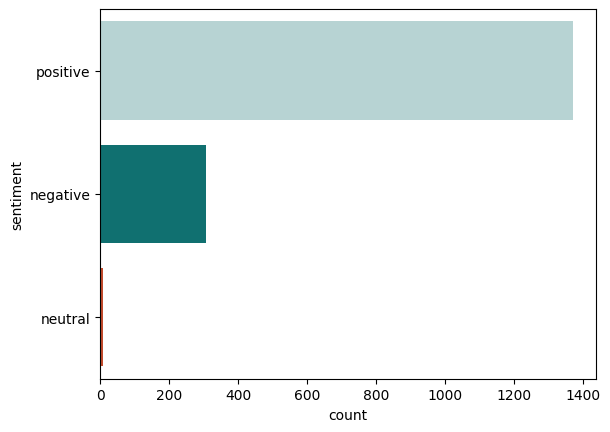

In [ ]:
# Number of tweets 
sns.countplot(y='sentiment', 
             data=result_df, 
             palette=['#b2d8d8',"#008080", '#db3d13']
             );

## NER (Named Entity Recognition)
Named Entity Recognition (NER) is a technique used in natural language processing. NER is used to recognize and label proper names, personal names, organizations, places, dates, currencies and other important entities in texts.

NER uses linguistic and statistical methods to recognize proper nouns or entities that belong to a particular category in a text. These entities are often expressed with words such as nouns, adjectives, verbs, or place names.

In [ ]:
# Tokenizing the lyrics by converting them to lowercase and applying word_tokenize
result_df['tokenized'] = result_df['prep_lyric'].str.lower().apply(word_tokenize)

# Performing part-of-speech tagging on the tokenized lyrics
result_df['tagged'] = result_df['tokenized'].apply(nltk.pos_tag)

# Extracting only the nouns from the tagged lyrics using a lambda function and list comprehension
result_df['nouns'] = result_df['tagged'].apply(lambda x: [word for word, tag in x if tag in ['NN', 'NNS', 'NNP', 'NNPS']])

# Dropping the 'tokenized' column since it is no longer needed
result_df.drop(["tokenized"], axis=1, inplace=True)

In [ ]:
#Tokenization and Sentence Splitting
lyrics = result_df['prep_lyric'].tolist()
tokenized_lyrics = [nltk.word_tokenize(lyric) for lyric in lyrics]
sentences = [nltk.sent_tokenize(lyric) for lyric in lyrics]

#Apply Named Entity Recognition
nlp = spacy.load('en_core_web_sm')
ner_results = []
for tokens in tokenized_lyrics:
    doc = nlp(' '.join(tokens))
    ner_results.append([(ent.text, ent.label_) for ent in doc.ents])

#Extract Relevant Entities
relevant_entities = []
for lyric_entities in ner_results:
    entities = [entity for entity, label in lyric_entities
                if label == 'GPE' or label == 'NORP']
    relevant_entities.append(entities)

#Extract Person/ORG Entities
person_org_entities = []
for lyric_entities in ner_results:
    entities = [entity for entity, label in lyric_entities
                if label == 'PERSON' or label == 'ORG']
    person_org_entities.append(entities)


#Add Results as a New Column to the Dataframe
result_df['extracted_entities'] = relevant_entities
result_df['extracted_entities_person_org'] = person_org_entities


In [ ]:
# Define a function to get the most frequent words in a given text
def get_most_frequent_words(text, top_n):
    words = nltk.word_tokenize(text.lower())  # Tokenize the text and convert to lowercase
    word_counts = Counter(words)  # Count the occurrences of each word
    return [word for word, count in word_counts.most_common(top_n)]  # Return the top n most common words

# Apply the get_most_frequent_words function to the 'prep_lyric' column and store the results in 'most_frequent_words'
# Replace '5' with the desired number of most frequent words
result_df['most_frequent_words'] = result_df['prep_lyric'].apply(lambda x: get_most_frequent_words(x, 5))


In [ ]:
result_df.head(1)

,Country,Artist,Song,Language,Pl.,Year,Lyrics translation,prep_lyric,Moving_On_and_Letting_Go,Emotional_Connections,Dreams_and_Wonder,Struggles_and_Determination,Joyful_Rhythms_and_Togetherness,dominant_topic,sentiment,tagged,nouns,extracted_entities,extracted_entities_person_org,most_frequent_words
0,Netherlands,Jetty Paerl,De vogels van Holland,Dutch,-,1956,The birds of Holland are so musical They alrea...,bird holland musical already learn twitter ear...,0.49,0.08,0.28,0.08,0.08,Moving_On_and_Letting_Go,positive,"[(bird, NN), (holland, VB), (musical, JJ), (al...","[bird, youth, blackbird, celebrate, spring, ho...","[blackbird, holland, holland, holland, french,...",[cheerfully holland],"[bird, holland, musical, nowhere, wonder]"


In [ ]:
result_df["Year_Period"] = np.where((result_df["Year"] >= 1956) & (result_df["Year"] <= 1959), "1956-1959",
                                    np.where((result_df["Year"] >= 1960) & (result_df["Year"] <= 1969), "1960-1969",
                                    np.where((result_df["Year"] >= 1970) & (result_df["Year"] <= 1979), "1970-1979",
                                    np.where((result_df["Year"] >= 1980) & (result_df["Year"] <= 1989), "1980-1989",
                                    np.where((result_df["Year"] >= 1990) & (result_df["Year"] <= 1999), "1990-1999",
                                    np.where((result_df["Year"] >= 2000) & (result_df["Year"] <= 2009), "2000-2009",
                                    np.where((result_df["Year"] >= 2010) & (result_df["Year"] <= 2022), "2010-2022",np.nan)))))))

In [ ]:
result_df = result_df.assign(nouns=result_df.nouns.map(' '.join))
result_df = result_df.assign(extracted_entities=result_df.extracted_entities.map(' '.join))
result_df = result_df.assign(extracted_entities_person_org=result_df.extracted_entities_person_org.map(' '.join))

In [ ]:
winner_df = result_df[result_df["Pl."] == "1"]
other_df = result_df[result_df["Pl."] != "1"]
print(winner_df.shape)
print(other_df.shape)

(69, 21)
(1615, 21)


# Visualization

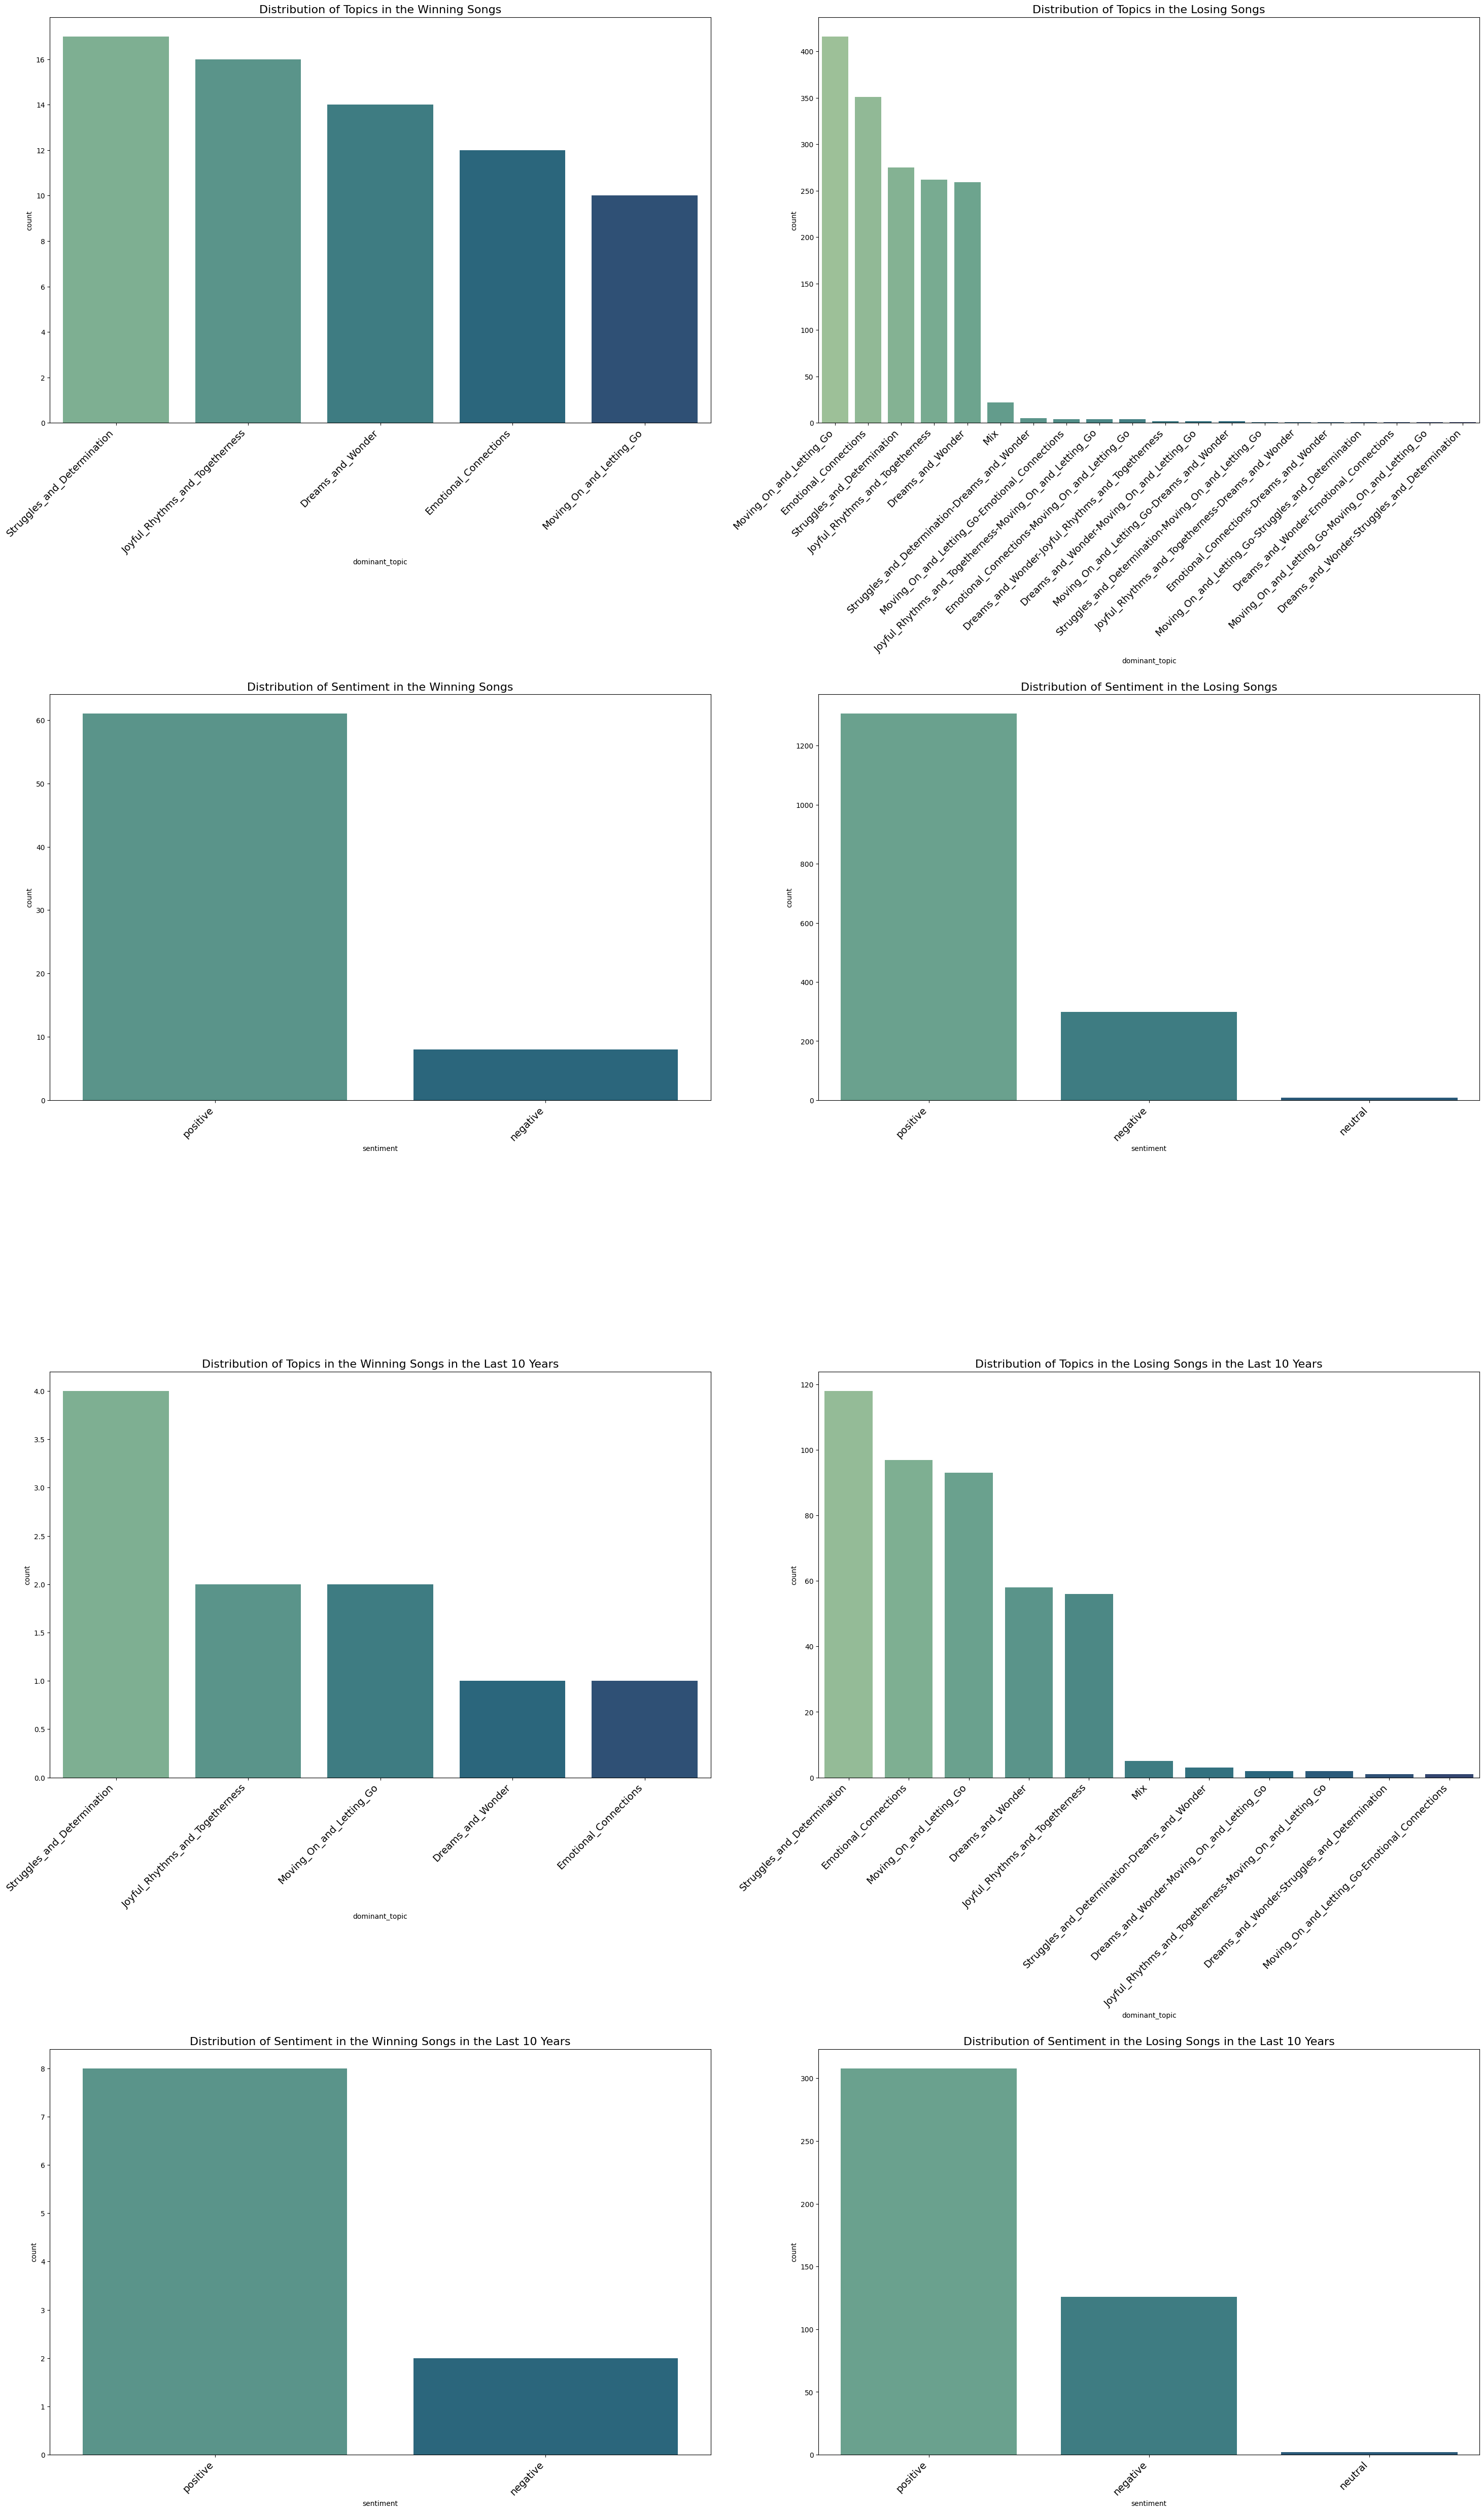

In [ ]:
fig, axes = plt.subplots(4,2, figsize=(30,50))
sns.set_palette("crest")

sns.countplot(ax = axes[0][0], x = winner_df["dominant_topic"], order=winner_df["dominant_topic"].value_counts().index, palette="crest");
axes[0][0].set_title("Distribution of Topics in the Winning Songs", fontdict={"fontsize": 16});
axes[0][0].set_xticklabels(axes[0][0].get_xticklabels(), rotation=45, ha="right", fontdict={"fontsize": 14})

sns.countplot(ax = axes[0][1], x = other_df["dominant_topic"], order=other_df["dominant_topic"].value_counts().index, palette="crest");
axes[0][1].set_title("Distribution of Topics in the Losing Songs", fontdict={"fontsize": 16});
axes[0][1].set_xticklabels(axes[0][1].get_xticklabels(), rotation=45, ha="right" ,fontdict={"fontsize": 14})

sns.countplot(ax = axes[1][0], x = winner_df["sentiment"], order=winner_df["sentiment"].value_counts().index, palette="crest");
axes[1][0].set_title("Distribution of Sentiment in the Winning Songs", fontdict={"fontsize": 16});
axes[1][0].set_xticklabels(axes[1][0].get_xticklabels(), rotation=45, ha="right",fontdict={"fontsize": 14})

sns.countplot(ax = axes[1][1], x = other_df["sentiment"], order=other_df["sentiment"].value_counts().index, palette="crest");
axes[1][1].set_title("Distribution of Sentiment in the Losing Songs", fontdict={"fontsize": 16});
axes[1][1].set_xticklabels(axes[1][1].get_xticklabels(), rotation=45, ha="right",fontdict={"fontsize": 14})

winner_last_ten_years = winner_df[winner_df["Year"] > 2011]
other_last_ten_years = other_df[other_df["Year"] > 2011]

sns.countplot(ax = axes[2][0], x = winner_last_ten_years["dominant_topic"], order=winner_last_ten_years["dominant_topic"].value_counts().index, palette="crest");
axes[2][0].set_title("Distribution of Topics in the Winning Songs in the Last 10 Years", fontdict={"fontsize": 16});
axes[2][0].set_xticklabels(axes[2][0].get_xticklabels(), rotation=45, ha="right",fontdict={"fontsize": 14})

sns.countplot(ax = axes[2][1], x = other_last_ten_years["dominant_topic"], order=other_last_ten_years["dominant_topic"].value_counts().index, palette="crest");
axes[2][1].set_title("Distribution of Topics in the Losing Songs in the Last 10 Years", fontdict={"fontsize": 16});
axes[2][1].set_xticklabels(axes[2][1].get_xticklabels(), rotation=45, ha="right",fontdict={"fontsize": 14})

sns.countplot(ax = axes[3][0], x = winner_last_ten_years["sentiment"], order=winner_last_ten_years["sentiment"].value_counts().index, palette="crest");
axes[3][0].set_title("Distribution of Sentiment in the Winning Songs in the Last 10 Years", fontdict={"fontsize": 16});
axes[3][0].set_xticklabels(axes[3][0].get_xticklabels(), rotation=45, ha="right",fontdict={"fontsize": 14})

sns.countplot(ax = axes[3][1], x = other_last_ten_years["sentiment"], order=other_last_ten_years["sentiment"].value_counts().index, palette="crest");
axes[3][1].set_title("Distribution of Sentiment in the Losing Songs in the Last 10 Years", fontdict={"fontsize": 16});
axes[3][1].set_xticklabels(axes[3][1].get_xticklabels(), rotation=45, ha="right",fontdict={"fontsize": 14})

plt.tight_layout(pad=2.5)  # Increase the pad value to adjust the spacing between subplots
plt.show()

The graphs above were examined first in general and then according to the last 10 years.

1. In the first two charts, the winning and losing songs were analyzed according to their topics. First of all, when we look at the winning songs, the most winning topic is Struggles and Determination, followed by Joyful Rhythms and Togethernes. Moving On and Letting Go is the theme that lost the most in recording songs, followed by Emotional Connections. Based on these two observations, songs with very emotional and separation-style themes are more likely to lose than others. Secondly, when the graph of the lost songs was examined, it was observed that the songs contained more than one topic. It indicates that the topic of this song is mixed and that songs with two or more such topics are lost. The conclusion to be drawn from this is that the songs should be focused on a certain topic in order to be understandable and influencing the person.

2. When the songs are analyzed according to emotion, we can see that the weight of positive songs is high both in general and for the last 10 years. The thing to note here is that songs that can be described as neutral are more likely to lose.

3. The themes of the songs in the last 10 years are also examined as they are close to the present. Here, when both the winning and losing songs are examined, the most frequently mentioned subject is Struggles and Determination. Therefore, it may be more risky to use this subject in new songs. It can be continued with the topic Joyful Rhythms and Togetherness.

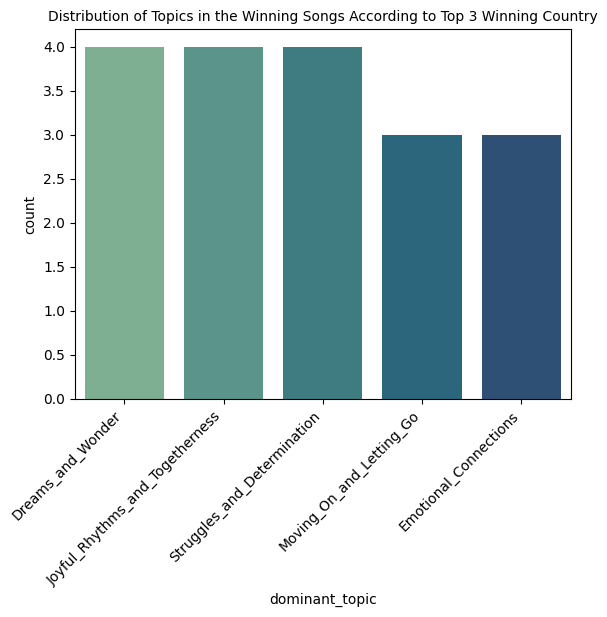

In [ ]:
# Count the number of occurrences for each country in the 'Country' column of the 'winner_df' DataFrame
winner_df.Country.value_counts()

# Filter the 'winner_df' DataFrame to include only the top 3 winning countries
winner_countries = winner_df[(winner_df["Country"]=="Ireland") | (winner_df["Country"]=="Sweden") | (winner_df["Country"]=="France")]

# Create a count plot of the dominant topics in the winning songs of the top 3 winning countries
sns.countplot(x = winner_countries["dominant_topic"], order=winner_countries["dominant_topic"].value_counts().index, palette="crest")

# Set the title of the plot and adjust the font size
plt.title("Distribution of Topics in the Winning Songs According to Top 3 Winning Country", fontdict={"fontsize": 10})

# Rotate the x-axis tick labels by 45 degrees and align them to the right
plt.xticks(rotation=45, ha="right")

# Display the plot
plt.show()

[('italian', 2), ('rise', 2), ('rockme,italian', 1), ('italian,moon', 1), ('moon', 1)]


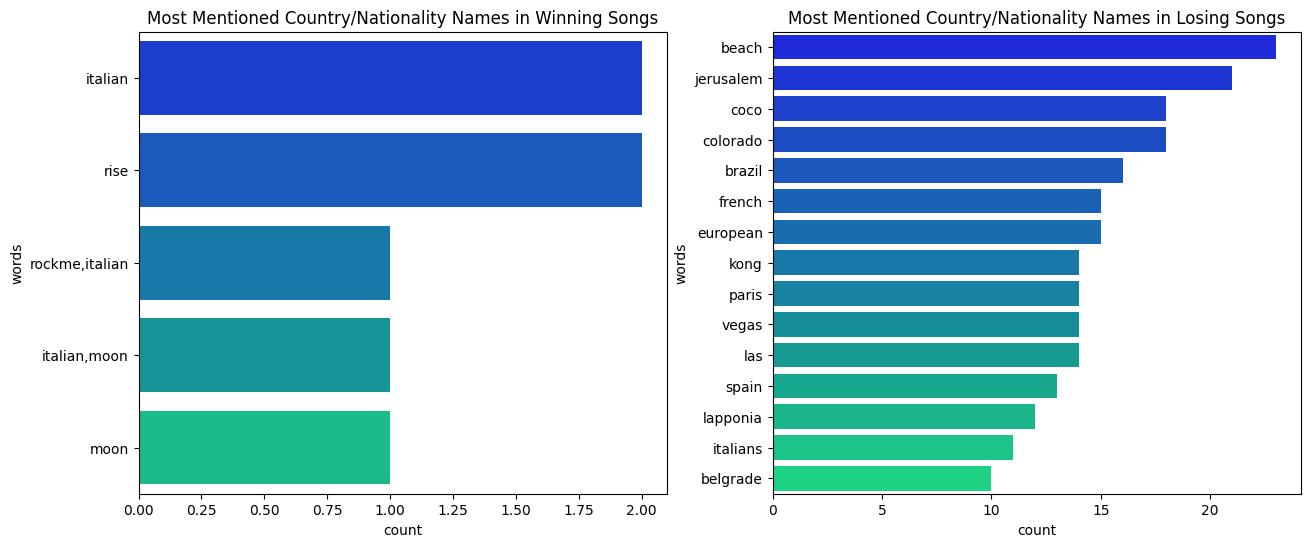

In [ ]:
# Join all word corpus
winner_list = [i for i in list(winner_df['extracted_entities'].values) if i]
winner_nouns = ','.join(winner_list)
other_nouns = ','.join(list(other_df['extracted_entities'].values))

# Count and find the 30 most frequent
counter = Counter(winner_nouns.split())
most_frequent_winner = counter.most_common(10)
print(most_frequent_winner)

counter_2 = Counter(other_nouns.split())
most_frequent_other = counter_2.most_common(15)

# Bar plot of frequent words
fig, axes = plt.subplots(1,2,figsize=(15,6))
sns.set_palette("crest")

_ = pd.DataFrame(most_frequent_winner, columns=("words","count"))
sns.barplot(ax = axes[0], x = 'count', y = 'words', data = _, palette = 'winter')
axes[0].set_title("Most Mentioned Country/Nationality Names in Winning Songs", fontdict={"fontsize": 12});

_ = pd.DataFrame(most_frequent_other, columns=("words","count"))
sns.barplot(ax = axes[1], x = 'count', y = 'words', data = _, palette = 'winter')
axes[1].set_title("Most Mentioned Country/Nationality Names in Losing Songs", fontdict={"fontsize": 12});

The two charts above show the analysis of Country/Nationality names from named entity recognition results by winning and losing songs. These charts show that songs with Country/Nationality-related words are more likely to be among the losing songs. For this reason, care should be taken not to mention the name of any nation or country while writing the songs.

[('waterloo', 16), ('escape', 3), ('honey', 2), ('long', 2), ('kick', 2), ('ray', 1), ('sunshine,lulu,sun', 1), ('draw', 1), ('bird,bench', 1), ('tree', 1)]


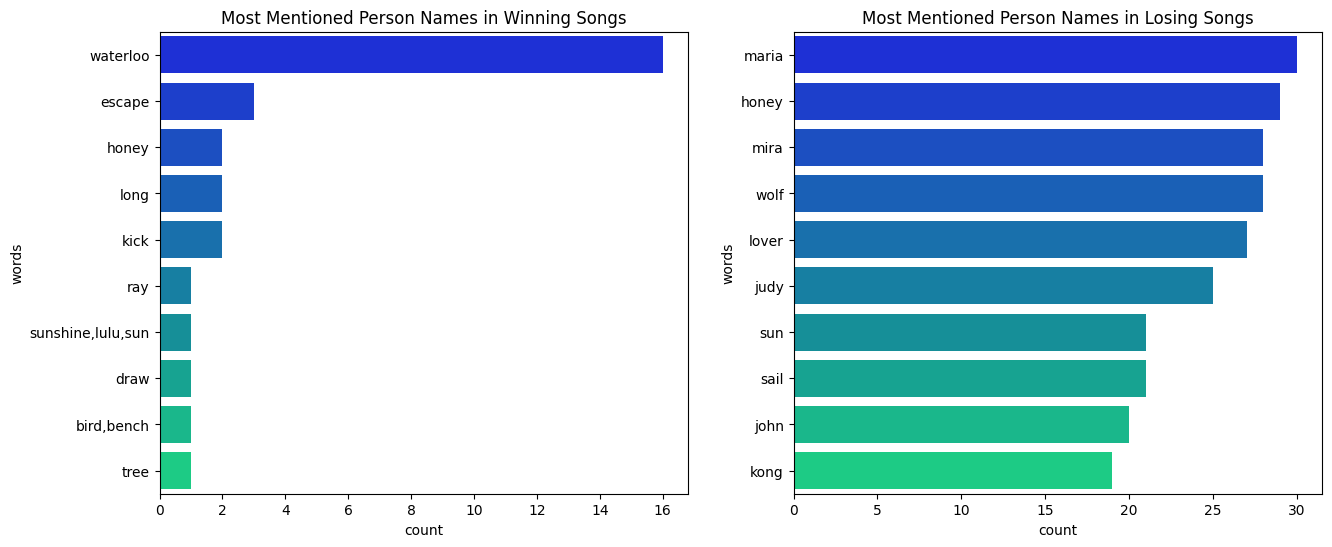

In [ ]:
# Join all word corpus
winner_list = [i for i in list(winner_df['extracted_entities_person_org'].values) if i]
winner_nouns = ','.join(winner_list)
other_nouns = ','.join(list(other_df['extracted_entities_person_org'].values))

# Count and find the 30 most frequent
counter = Counter(winner_nouns.split())
most_frequent_winner = counter.most_common(10)
print(most_frequent_winner)

counter_2 = Counter(other_nouns.split())
most_frequent_other = counter_2.most_common(10)

# Bar plot of frequent words
fig, axes = plt.subplots(1,2,figsize=(15,6))
sns.set_palette("crest")

_ = pd.DataFrame(most_frequent_winner, columns=("words","count"))
sns.barplot(ax = axes[0], x = 'count', y = 'words', data = _, palette = 'winter')
axes[0].set_title("Most Mentioned Person Names in Winning Songs", fontdict={"fontsize": 12});

_ = pd.DataFrame(most_frequent_other, columns=("words","count"))
sns.barplot(ax = axes[1], x = 'count', y = 'words', data = _, palette = 'winter')
axes[1].set_title("Most Mentioned Person Names in Losing Songs", fontdict={"fontsize": 12});

In the above graph, similar to the examination of countries and nationalities, this time the names of individuals mentioned in the songs have been taken into account. When examining the graphs, it has been determined that there are slightly more personal names in the losing songs compared to the winning songs, although there is a small difference. Therefore, while it is not directly recommended to exclude personal names, caution is advised when using them.

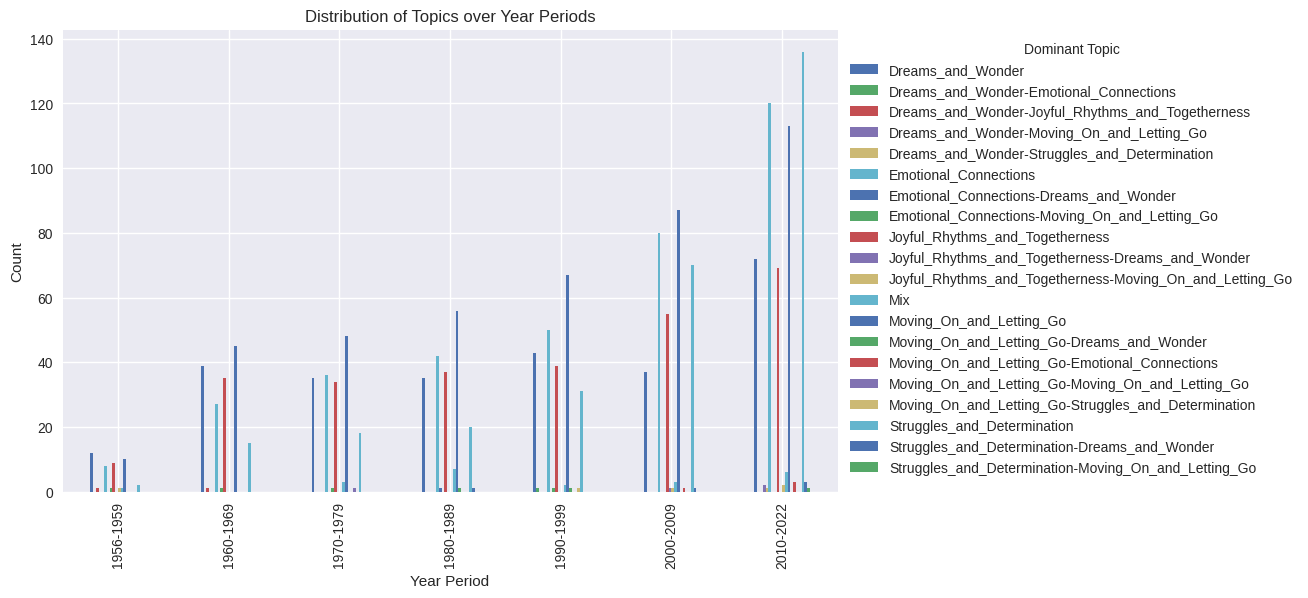

In [ ]:
# Group the data by year periods and topics
grouped_data = result_df.groupby(['Year_Period', 'dominant_topic']).size().unstack()

# Set the plot style
plt.style.use('seaborn')

# Plot the bar chart
grouped_data.plot(kind='bar', stacked=False, figsize=(10, 6))

# Set the plot title and labels
plt.title('Distribution of Topics over Year Periods')
plt.xlabel('Year Period')
plt.ylabel('Count')

# Display the legend
plt.legend(title='Dominant Topic', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()


In the chart above, the distribution and change of the subjects according to the years are examined. According to this graphic, the subject of Moving on and Letting Go was at the forefront at the beginning, but it has left its place to the subject of Struggles and Determination towards the present day.